# Random Forest - Production - NoClassBalancing

In [1]:
import pandas as pd
import psycopg2 as pg
import sqlalchemy
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib as plt

In [2]:
conn = pg.connect("dbname=COVID user=postgres password=*********")
full_results_df = pd.read_sql("SELECT * FROM covid_ml", conn)

full_results_df

,res_state,age_group,sex,race,symptom_status,hosp_yn,icu_yn,death_yn,underlying_health_conditions,outcome
0,IA,50 to 64 years,Male,White,Symptomatic,Yes,No,No,Yes,None
1,OH,18 to 49 years,Female,Multiple/Other,Symptomatic,No,No,No,Yes,None
2,IA,0 - 17 years,Male,White,Symptomatic,No,No,No,Yes,None
3,KS,18 to 49 years,Female,White,Symptomatic,No,No,No,Yes,None
4,OH,18 to 49 years,Male,White,Symptomatic,No,No,No,Yes,None
...,...,...,...,...,...,...,...,...,...,...
222316,NC,18 to 49 years,Male,White,Symptomatic,Yes,No,No,Yes,None
222317,NC,65+ years,Male,White,Symptomatic,Yes,Yes,Yes,Yes,None
222318,OK,18 to 49 years,Male,White,Symptomatic,No,No,No,No,None
222319,OK,18 to 49 years,Female,White,Symptomatic,No,No,No,Yes,None


In [3]:
# Make a copy of original df
results_df = full_results_df.copy()

In [4]:
# Populate "outcome" column
for idx, row in results_df.iterrows():
    if row['death_yn'] == "Yes":
        row['outcome'] = "severe"
 
    elif row['hosp_yn'] != "Yes" and row['icu_yn'] != "Yes" and row['death_yn'] != "Yes":
        row['outcome'] = "mild"
           
    elif row['hosp_yn'] != "Yes" and row['icu_yn'] == "Yes" and row['death_yn'] != "Yes":
        row['outcome'] = "severe"
        
    elif row['hosp_yn'] == "Yes" and row['icu_yn'] != "Yes" and row['death_yn'] != "Yes":
        row['outcome'] = "severe"

    elif row['hosp_yn'] == "Yes" and row['icu_yn'] == "Yes" and row['death_yn'] != "Yes":
        row['outcome'] = "severe"
    
    else:
        row['outcome'] = "mild"


# Print the contents and counts of the "outcome" column
outcome_counts = results_df.outcome.value_counts()
print(outcome_counts)

mild      193292
severe     29029
Name: outcome, dtype: int64


In [5]:
results_df = results_df.drop(['hosp_yn'], axis=1)
results_df = results_df.drop(['icu_yn'], axis=1)
results_df = results_df.drop(['death_yn'], axis=1)
results_df

,res_state,age_group,sex,race,symptom_status,underlying_health_conditions,outcome
0,IA,50 to 64 years,Male,White,Symptomatic,Yes,severe
1,OH,18 to 49 years,Female,Multiple/Other,Symptomatic,Yes,mild
2,IA,0 - 17 years,Male,White,Symptomatic,Yes,mild
3,KS,18 to 49 years,Female,White,Symptomatic,Yes,mild
4,OH,18 to 49 years,Male,White,Symptomatic,Yes,mild
...,...,...,...,...,...,...,...
222316,NC,18 to 49 years,Male,White,Symptomatic,Yes,severe
222317,NC,65+ years,Male,White,Symptomatic,Yes,severe
222318,OK,18 to 49 years,Male,White,Symptomatic,No,mild
222319,OK,18 to 49 years,Female,White,Symptomatic,Yes,mild


In [6]:
# Print the contents and counts of the "outcome" column
age_group_counts = results_df.age_group.value_counts()
print(age_group_counts)
print("")

sex_counts = results_df.sex.value_counts()
print(sex_counts)
print("")

race_counts = results_df.race.value_counts()
print(race_counts)
print("")

#exp_counts = results_df.exposure_yn.value_counts()
#print(exp_counts)
#print("")

symptom_counts = results_df.symptom_status.value_counts()
print(symptom_counts)
print("")

condition_counts = results_df.underlying_health_conditions.value_counts()
print(condition_counts)
print("")

outcome_counts = results_df.outcome.value_counts()
print(outcome_counts)

18 to 49 years    105329
50 to 64 years     51900
65+ years          49704
0 - 17 years       15388
Name: age_group, dtype: int64

Female    127129
Male       95192
Name: sex, dtype: int64

White                                     191069
Black                                      20532
Multiple/Other                              5372
Asian                                       3903
Native Hawaiian/Other Pacific Islander      1079
American Indian/Alaska Native                366
Name: race, dtype: int64

Symptomatic     214356
Asymptomatic      7965
Name: symptom_status, dtype: int64

Yes    202763
No      19558
Name: underlying_health_conditions, dtype: int64

mild      193292
severe     29029
Name: outcome, dtype: int64


In [7]:
# Bar graph of outcome
import numpy as np
import matplotlib.pyplot as plt

# creating the dataset
mild = results_df['outcome']=='mild'
mild = results_df[results_df['outcome']=='mild']
mild = mild['outcome'].count()

severe = results_df['outcome']=='severe'
severe = results_df[results_df['outcome']=='severe']
severe = severe['outcome'].count()

outcome = {"Mild": mild, "Severe": severe}
category = list(outcome.keys())
count = list(outcome.values())
print(category)
print(count)

['Mild', 'Severe']
[193292, 29029]


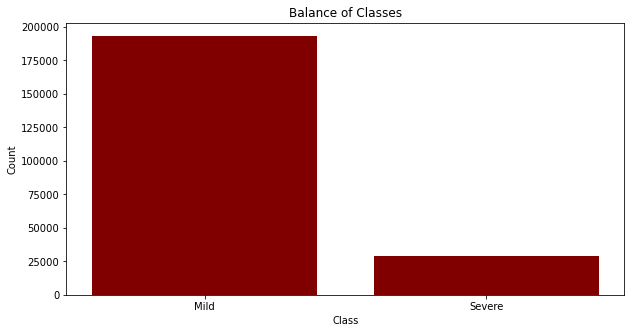

In [8]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(category, count, color = 'maroon')
 
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Balance of Classes")
plt.show()

In [9]:
part_encoded_df = results_df.copy()

# Encode with "get_dummies"
part_encoded_df = pd.get_dummies(part_encoded_df, columns=['res_state','race'])

# Encode "outcome" and "age_group"
le=LabelEncoder()

age_num={'0 - 17 years': 0, '18 to 49 years': 1, '50 to 64 years': 2, '65+ years': 3, 'Missing': 4}
part_encoded_df['age_num']=part_encoded_df['age_group'].apply(lambda x: age_num[x])

outcome_num={'mild': 0, 'severe': 1}
part_encoded_df['outcome_num']=part_encoded_df['outcome'].apply(lambda x: outcome_num[x])

part_encoded_df['sex'] = le.fit_transform(part_encoded_df['sex'])
part_encoded_df['symptom_status'] = le.fit_transform(part_encoded_df['symptom_status'])
part_encoded_df['underlying_health_conditions'] = le.fit_transform(part_encoded_df['underlying_health_conditions'])

results_encoded_df = part_encoded_df.copy()
results_encoded_df

,age_group,sex,symptom_status,underlying_health_conditions,outcome,res_state_AK,res_state_AL,res_state_AR,res_state_CO,res_state_DC,...,res_state_WI,res_state_WY,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White,age_num,outcome_num
0,50 to 64 years,1,1,1,severe,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,1
1,18 to 49 years,0,1,1,mild,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0 - 17 years,1,1,1,mild,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,18 to 49 years,0,1,1,mild,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,18 to 49 years,1,1,1,mild,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222316,18 to 49 years,1,1,1,severe,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
222317,65+ years,1,1,1,severe,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,1
222318,18 to 49 years,1,1,0,mild,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
222319,18 to 49 years,0,1,1,mild,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [10]:
# Drop le encoded columns
results_encoded_df = results_encoded_df.drop(['age_group'], axis=1)
results_encoded_df = results_encoded_df.drop(['outcome'], axis=1)
results_encoded_df

,sex,symptom_status,underlying_health_conditions,res_state_AK,res_state_AL,res_state_AR,res_state_CO,res_state_DC,res_state_FL,res_state_GA,...,res_state_WI,res_state_WY,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White,age_num,outcome_num
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,1
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222316,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
222317,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,1
222318,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
222319,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [11]:
X = results_encoded_df.copy()
X = X.drop("outcome_num", axis=1)
X

,sex,symptom_status,underlying_health_conditions,res_state_AK,res_state_AL,res_state_AR,res_state_CO,res_state_DC,res_state_FL,res_state_GA,...,res_state_WA,res_state_WI,res_state_WY,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White,age_num
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222316,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
222317,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
222318,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
222319,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [12]:
y = results_encoded_df["outcome_num"].values
y

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(166740, 48)
(55581, 48)
(166740,)
(55581,)


# Random Forest Model

In [14]:
# Create the model
rf_model=RandomForestClassifier(n_estimators=500)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)
print("Training Data Score: %.3f" % rf_model.score(X_train, y_train))
print("Test Data Score: %.3f" % rf_model.score(X_test, y_test))

# Predictions
predictions = rf_model.predict(X_test)

Training Data Score: 0.907
Test Data Score: 0.907


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cm_df=pd.DataFrame(cm)
cm_df=pd.DataFrame(
    cm, index=["Actual Mild", "Actual Severe"],
    columns=["Predicted Mild", "Predicted Severe"])
cm_df

,Predicted Mild,Predicted Severe
Actual Mild,48198,126
Actual Severe,5065,2192


In [16]:
acc_score=accuracy_score(y_test, predictions)
print("Accuracy Score")
print(acc_score)

Accuracy Score
0.906604775013044


In [17]:
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     48324
           1       0.95      0.30      0.46      7257

    accuracy                           0.91     55581
   macro avg       0.93      0.65      0.70     55581
weighted avg       0.91      0.91      0.88     55581



In [18]:
# Calculate feature importance in the Random Forest Model
importance = rf_model.feature_importances_
importance

array([7.03803603e-03, 8.68458419e-03, 1.40721950e-02, 1.23055369e-03,
       0.00000000e+00, 5.09226621e-05, 1.73515145e-03, 2.99825477e-03,
       3.54550657e-04, 6.52655577e-05, 8.74661084e-03, 2.10831958e-02,
       1.45551739e-04, 7.05630907e-03, 1.78498658e-01, 1.32641162e-02,
       1.80684375e-05, 3.45064008e-01, 4.23650194e-06, 6.26910194e-05,
       0.00000000e+00, 3.45579589e-02, 7.60168178e-05, 1.28566591e-02,
       1.60392143e-05, 9.68590948e-03, 7.95659185e-03, 1.46921549e-02,
       8.12104333e-06, 3.69313525e-07, 8.98125546e-03, 8.70981985e-04,
       9.34029319e-05, 6.17172546e-03, 1.42228243e-02, 6.47278360e-05,
       6.99071763e-04, 7.97475135e-03, 4.99226894e-03, 1.58289944e-06,
       8.46439697e-03, 4.63190641e-04, 8.92651213e-04, 4.93604571e-03,
       1.45121487e-03, 9.61838345e-04, 5.07505334e-03, 2.43660236e-01])

In [19]:
# Sort the features by importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.3450640080552115, 'res_state_MN'),
 (0.24366023550561755, 'age_num'),
 (0.17849865829462852, 'res_state_KY'),
 (0.03455795888766002, 'res_state_NC'),
 (0.02108319578620972, 'res_state_ID'),
 (0.014692154929546812, 'res_state_OH'),
 (0.014222824253224813, 'res_state_UT'),
 (0.014072195000398057, 'underlying_health_conditions'),
 (0.013264116151560802, 'res_state_LA'),
 (0.012856659082615879, 'res_state_NJ'),
 (0.009685909484921564, 'res_state_NV'),
 (0.008981255455764281, 'res_state_PA'),
 (0.008746610841970292, 'res_state_IA'),
 (0.008684584192365634, 'symptom_status'),
 (0.00846439696704583, 'res_state_WY'),
 (0.007974751351416145, 'res_state_VT'),
 (0.007956591848223744, 'res_state_NY'),
 (0.007056309073026371, 'res_state_KS'),
 (0.007038036029129525, 'sex'),
 (0.006171725456973071, 'res_state_TN'),
 (0.00507505333591294, 'race_White'),
 (0.004992268939918574, 'res_state_WA'),
 (0.004936045712212312, 'race_Black'),
 (0.0029982547733735368, 'res_state_DC'),
 (0.001735151453543691,